In [1]:
from util.solver import Solver
from util.parser import get_parser
from util.calculate2 import calculate
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

args = get_parser().parse_args(args=['--name', 'Shenzhen',  '--mode', 'train' ,'--data_dir', 'datasets/Shenzhen',  '--color_file', 'data/Shenzhen.txt', '--img_size', '512', '--batch_size', '1'])

def load_styles(args):
    style_dir = os.path.join('styles',args.name)
    if os.path.exists(style_dir):
        styles = np.load(os.path.join(style_dir,'styles.npy'))
        properties = np.load(os.path.join(style_dir,'s_properties.npy'))
    else:
        raise
    return styles.squeeze(),properties.squeeze()

styles,properties = load_styles(args)

data = pd.DataFrame(properties,columns=['bcr_direction','far_direction','kd_direction'])
print(data.head())

   bcr_direction  far_direction  kd_direction
0       0.159384       1.007506     -0.484333
1       0.069425       0.644362      1.567232
2       0.162222       0.961328      0.171368
3       0.089144       1.633563     -0.447230
4       0.122987       0.850591     -0.571030


In [2]:
%%time
from sklearn.linear_model import LogisticRegression
filename = ['bcr_direction','far_direction','kd_direction']

for idx in range(3):
    median = np.median(properties[:,idx])
    X_data = styles
    y_data = np.float32(properties[:,idx]>median)

    # So let's find the gender direction in the latent space
    clf = LogisticRegression(class_weight='balanced',max_iter=1000).fit(X_data, y_data)
    direction = clf.coef_
    np.save(r'styles/%s/%s.npy'%(args.name,filename[idx]),direction)


CPU times: total: 1.88 s
Wall time: 313 ms


In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

args.batch_size=1
solver = Solver(args)
solver.load_model(latest=True)
img,seg = next(iter(solver.data['train']))

@torch.no_grad()
def generate_image(seg,latent_vector):
    latent_vector = torch.Tensor(latent_vector).to(solver.device)
    seg = seg.to(solver.device)
    gen_img = solver.nets.generator(seg,latent_vector)
    gen_img = transforms.ToPILImage()(gen_img[0])
    gen_img = np.array(gen_img)

    return gen_img

def show(latent_vector):
    fig,ax = plt.subplots(1, latent_vector.shape[0], figsize=(15, 10), dpi=80)



def move_and_show(latent_vector, direction=None, coeffs=None):
    
    if latent_vector.shape[0] > 1:
        fig,ax = plt.subplots(1, latent_vector.shape[0], figsize=(15, 10), dpi=80)
        for i in range(latent_vector.shape[0]):
            new_latent_vector = np.expand_dims(latent_vector[i],axis=0)
            ax[i].imshow(generate_image(seg,new_latent_vector))
            ax[i].set_title('%s' % i)
    elif coeffs !=None:
        fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
        for i, coeff in enumerate(coeffs):
            new_latent_vector = latent_vector.copy()
            new_latent_vector = (latent_vector + coeff*direction)
            ax[i].imshow(generate_image(seg,new_latent_vector))
            ax[i].set_title('Coeff: %0.1f' % coeff)
    else:
        raise
    [x.axis('off') for x in ax]
    plt.show()

load model : latest
load model : latest
load model : latest


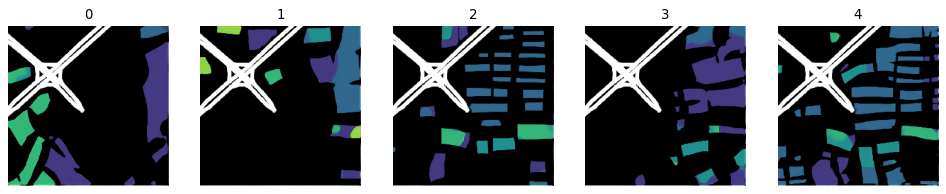

In [12]:
import random
latent_vector = styles[random.sample(range(999),5)]
move_and_show(latent_vector)

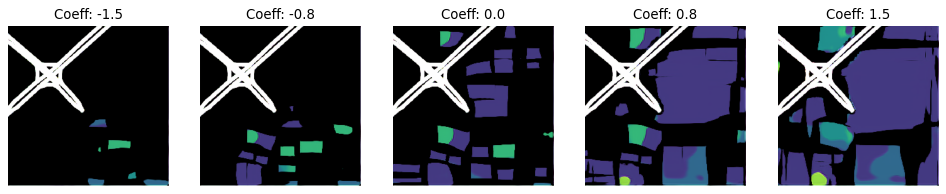

In [9]:
#BCR
latent_vector = np.expand_dims(styles[2],axis=0)
direction = np.load(r'styles/%s/bcr_direction.npy'%args.name)
move_and_show(latent_vector,direction,[-1.5, -0.75, 0, 0.75, 1.5])

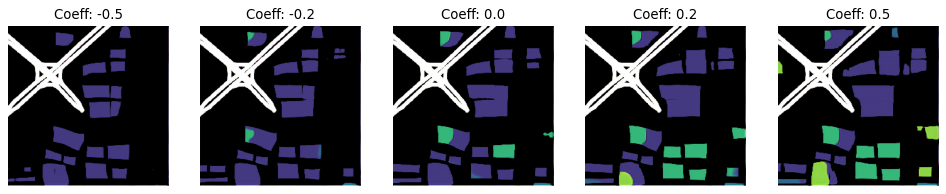

In [10]:
#FAR
latent_vector = np.expand_dims(styles[2],axis=0)
direction = np.load(r'styles/%s/far_direction.npy'%args.name)
move_and_show(latent_vector,direction,[-0.5, -0.25, 0, 0.25, 0.5])